# Nov 1,18 2024: Community realizations across modes

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
from numpy import linalg
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import jensenshannon
from multiprocessing import Pool
import glob
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations
from collections import Counter
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results_v2/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
parcels_img = ants.image_read(f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{PARC_DESC}_desc-labels.txt')

In [6]:
def get_membership_matrix(args, df):
    num_modes = len(df)
    num_comms = np.max(df['pi'].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0]['pi'].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df[df['mode_id'] == idx_mode]['pi'].to_list()[0]
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

def get_presence_of_comms_per_sub(args, df):
    omegas = df['omega'].to_numpy()
    M = get_membership_matrix(args, df)
    presence = np.any(M > 0.1, axis=0).astype(int) # in which modes does a comm occur
    return presence

In [7]:
def find_clusters(args, X):
    D = cosine_distances(X.T) / 2 # rescaling to range [0, 1]
    clustering = DBSCAN(eps=args.eps, min_samples=1)
    grps = clustering.fit_predict(D)
    return D, grps

def get_unique_profiles_and_strengths_per_comm(args, sub, comm, X, omegas, level=-1):
    D, grps = find_clusters(args, X)

    U = []
    S = []
    for g in np.unique(grps):
        U += [np.round(np.mean(X[:, grps == g], axis=-1), decimals=3)]
        S += [np.sum(omegas[grps == g])]
    # some profiles can be 0 vectors, need to use them for presence/absence of the communities
    return pd.DataFrame(dict(
        sub=[sub]*len(S),
        level=[level]*len(S),
        comm=[comm]*len(S),
        profile=U,
        strength=S
    )).sort_values(by=['strength'], ascending=False)

def get_community_profiles_per_sub(args, df, level=-1):
    sub = df.iloc[0]['sub']
    omegas = df['omega'].to_numpy()
    M = get_membership_matrix(args, df)
    presence = get_presence_of_comms_per_sub(args, df)

    profiles_sub_df = []
    for comm in range(M.shape[-1]):
        comm_M = M[:, :, comm]
        selected_modes = np.where(presence[:, comm])[0]
        try:
            prow = get_unique_profiles_and_strengths_per_comm(
                args, sub, comm, 
                comm_M[:, selected_modes], 
                omegas[selected_modes], 
                level=level
            )
            # comm_Ps = np.stack(prow['profile'].to_list(), axis=-1)
            profiles_sub_df += [prow]
        except:
            pass
    profiles_sub_df = pd.concat(profiles_sub_df).reset_index(drop=True)
    return profiles_sub_df

def get_community_profiles(args, indiv_files):
    profiles_df = []
    for indiv_file in tqdm(indiv_files):
        with open(indiv_file, 'rb') as f:
            indiv_marginals_df = pickle.load(f)
        
        indiv_marginals_df['pi'] = indiv_marginals_df['pi'].apply(lambda pi: np.round(pi, decimals=3))

        if args.sbm in ['a', 'd']:
            df = indiv_marginals_df
            profiles_sub_df = get_community_profiles_per_sub(args, df, level=-1)
            profiles_df += [profiles_sub_df]
        if args.sbm in ['h']:
            for level in indiv_marginals_df['level'].unique():
                df = indiv_marginals_df[indiv_marginals_df['level'] == level]
                profiles_sub_df = get_community_profiles_per_sub(args, df, level=level)
                profiles_df += [profiles_sub_df]
        # break
    return pd.concat(profiles_df).reset_index(drop=True)

def save_community_profiles(args, profiles_df):
    for key, group in profiles_df.groupby(by=['sub', 'level', 'comm']):
        # display(group)
        sub, level, comm = key
        out_folder = f'{ESTIM_path}/individual/sub-{sub}/community-profiles/{SBM}'
        if level != -1: out_folder += f'/level-{level}'
        os.system(f'mkdir -p {out_folder}')
        group.to_pickle(f'{out_folder}/comm-{comm:02d}_desc-unique-profiles.pkl')
        # break
    return None

In [8]:
def get_group_level_num_unique_comm_profiles(args, profiles_df, level=-1):
    comms = profiles_df['comm'].unique()
    num_unique_profiles = []
    for comm in comms:
        num_unique_profiles += [profiles_df[profiles_df['comm'] == comm]['sub'].value_counts().sort_index().mode().to_list()]

    max_num_unique = np.max([item for sublist in num_unique_profiles for item in sublist])
    MLB = MultiLabelBinarizer(classes=list(range(max_num_unique+1))).fit_transform(num_unique_profiles)

    fig, axs = plt.subplots(1, 1, figsize=(4, 6), dpi=90)
    ax = axs
    sns.heatmap(MLB, ax=ax, cmap=cc.cm.CET_L12, linewidths=0.5)
    title = f'{SBM}' if level == -1 else f'{SBM}_level-{level}'
    ax.set(xlabel=f'#unique profiles', ylabel=f'comm', title=title)

    return MLB, fig

def group_level_num_profiles(args, df, level=-1):
    cdf = []
    for comm, group in df.groupby('comm'):
        counts = group['sub'].value_counts().to_list()
        cdf += [
            pd.DataFrame({
                'comm': [comm],
                'counts': [counts],
            })
        ]
    cdf = pd.concat(cdf).reset_index(drop=True)
    cdf = cdf.explode(column='counts').reset_index(drop=True)

    fig, axs = plt.subplots(1, 1, figsize=(11, 3))
    ax = axs
    sns.boxplot(cdf, x='comm', y='counts', ax=ax, fill=False)
    sns.stripplot(cdf, x='comm', y='counts', ax=ax, jitter=True)
    title = f'{SBM}'
    if level != -1: title += f'_level-{level}'
    ax.set(title=title)
    ax.grid(alpha=0.3)
    return fig

In [9]:
sbms_list = [
    (True, 'a'),
    (True, 'd'),
    (True, 'h'),
    (False, 'd'),
    (False, 'h'),
]

sbm--a


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm--a/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/gr

100%|██████████| 10/10 [00:00<00:00, 22.14it/s]


sbm-dc-d


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-dc-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-dc-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-dc-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:00<00:00, 28.42it/s]


sbm-dc-h


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-dc-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-dc-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-dc-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:00<00:00, 13.47it/s]


sbm-nd-d


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-nd-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-nd-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-nd-d/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:00<00:00, 27.91it/s]


sbm-nd-h


['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-nd-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-nd-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-ses/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-nd-h/desc-marginals-df.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-

100%|██████████| 10/10 [00:00<00:00, 12.15it/s]


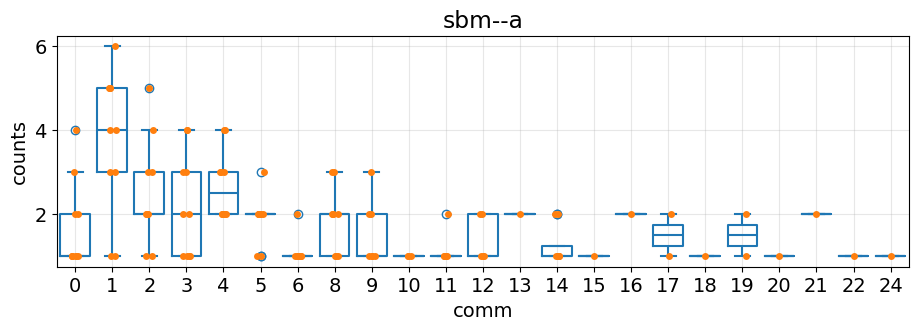

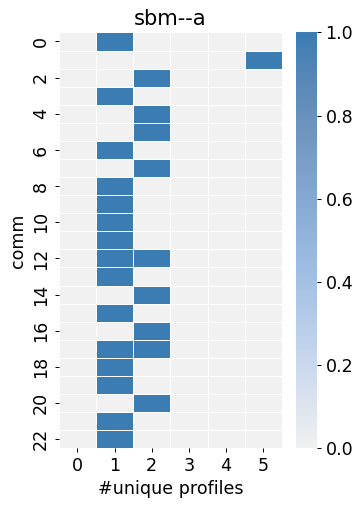

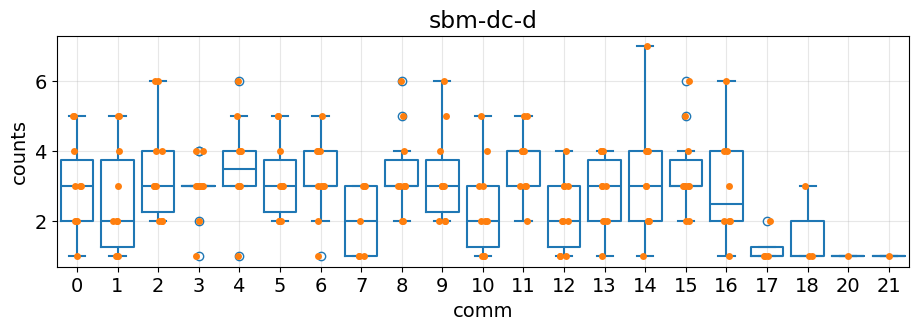

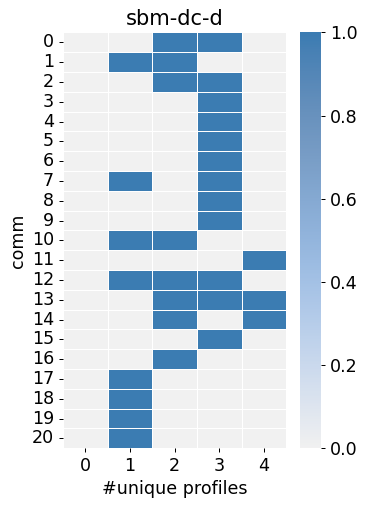

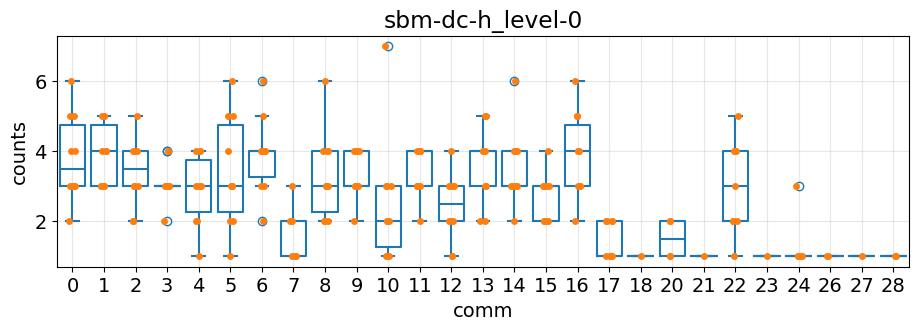

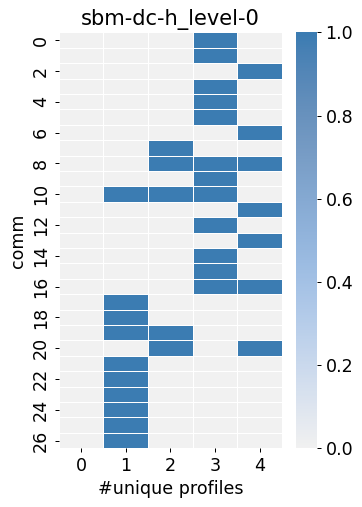

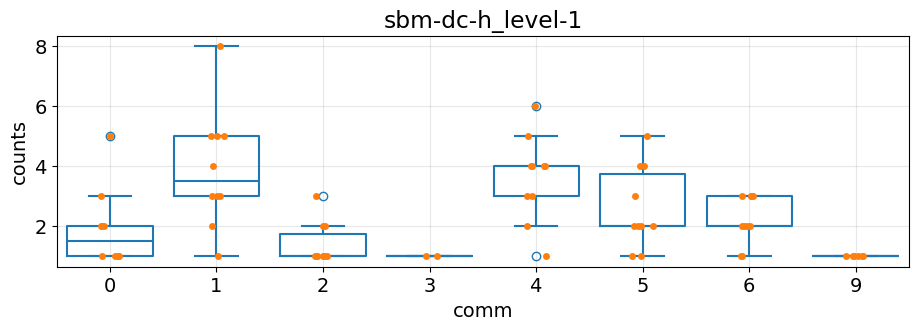

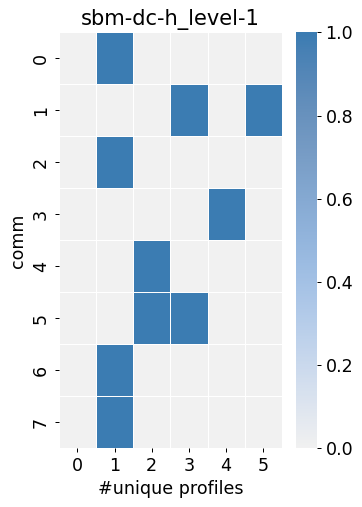

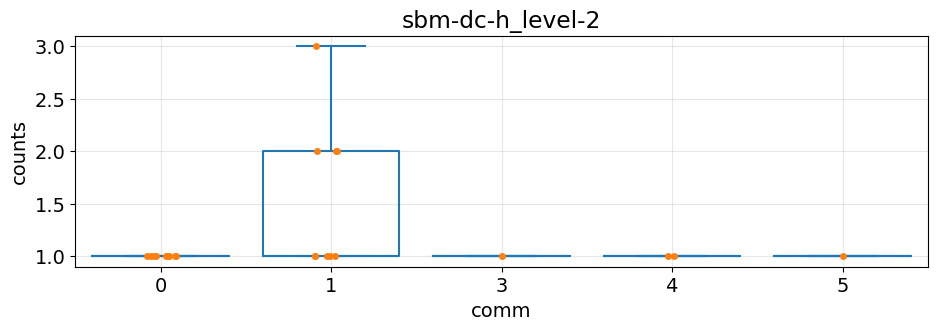

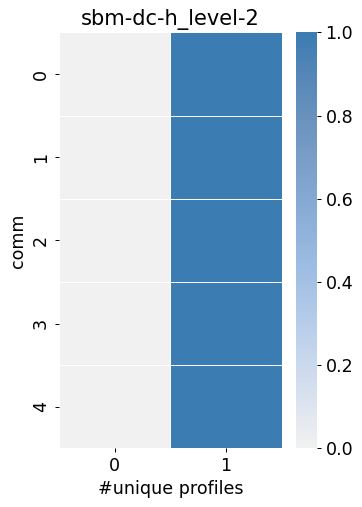

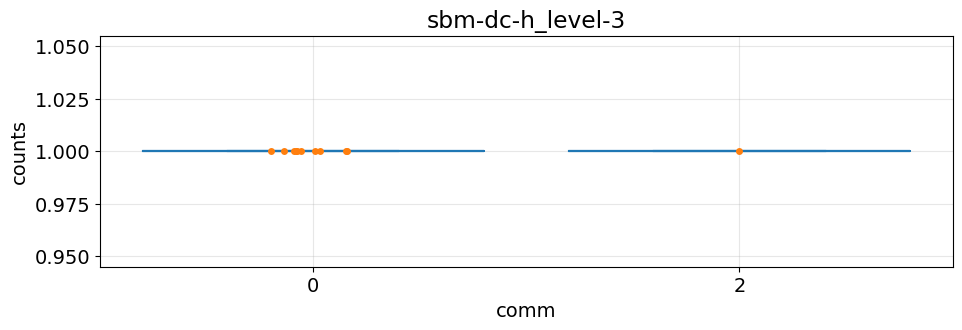

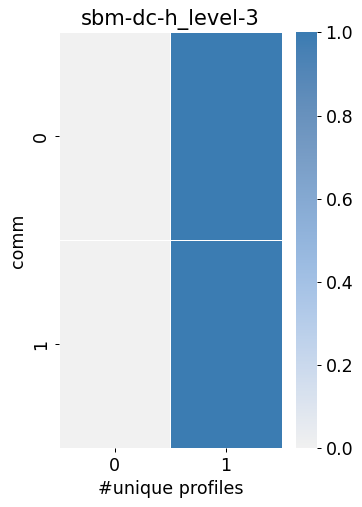

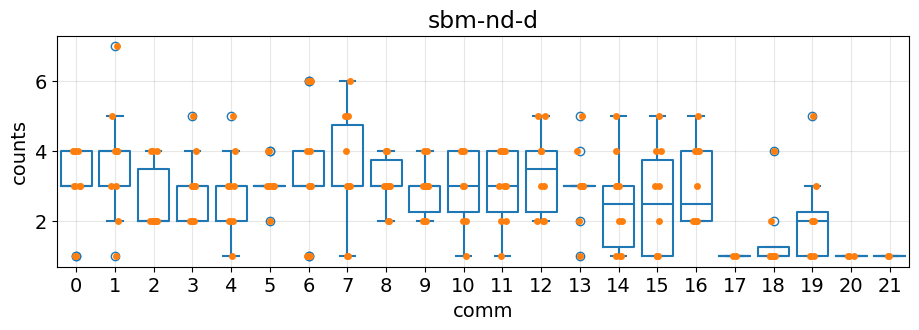

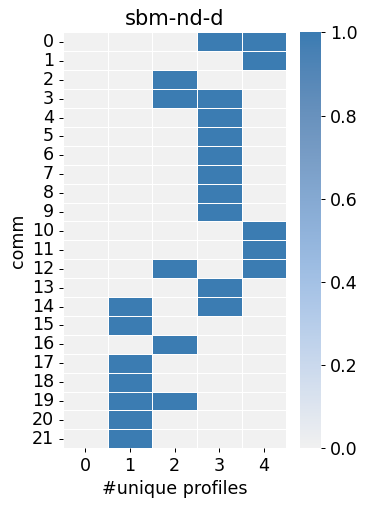

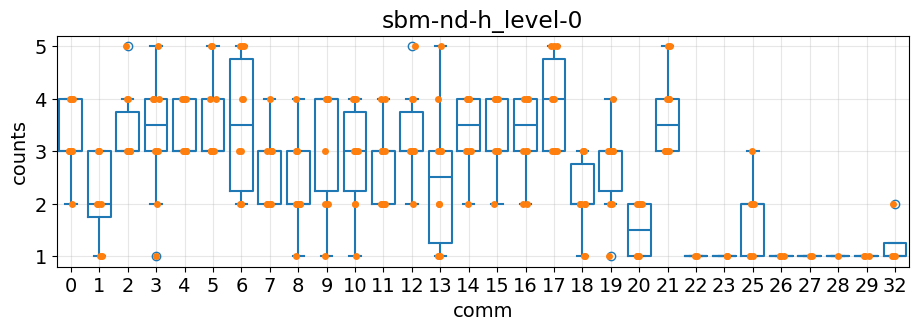

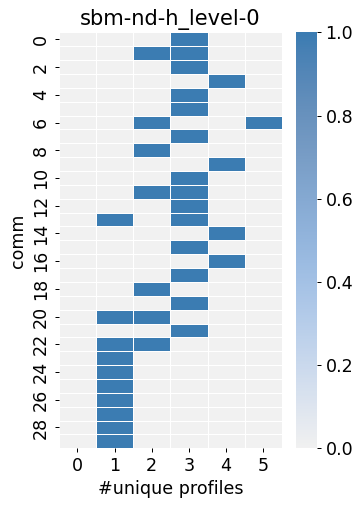

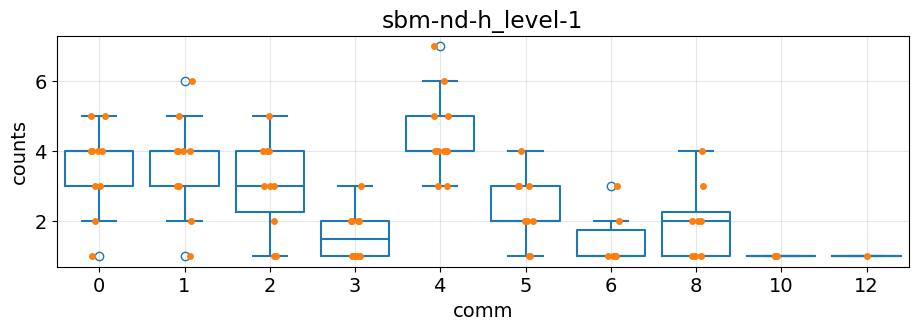

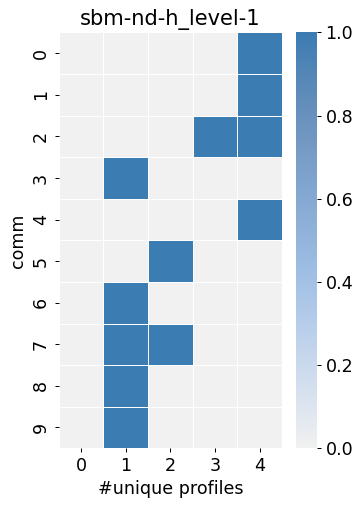

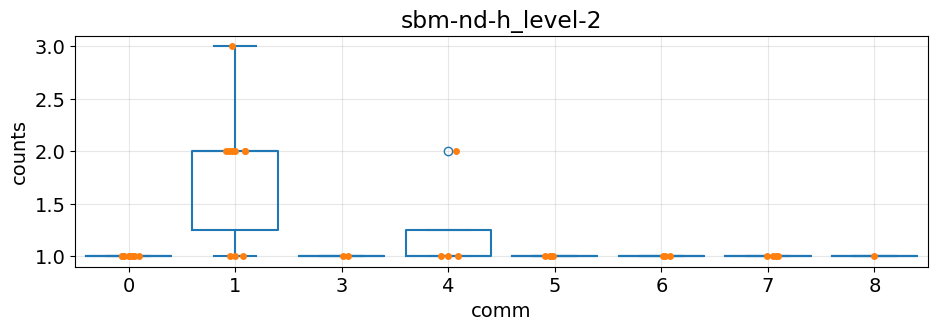

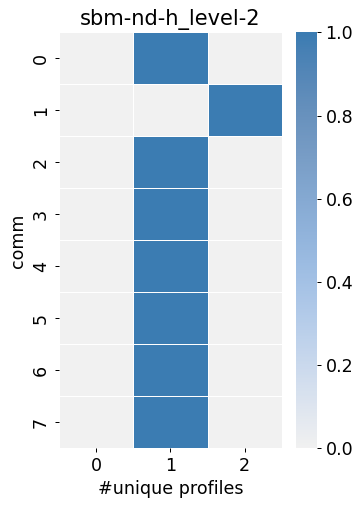

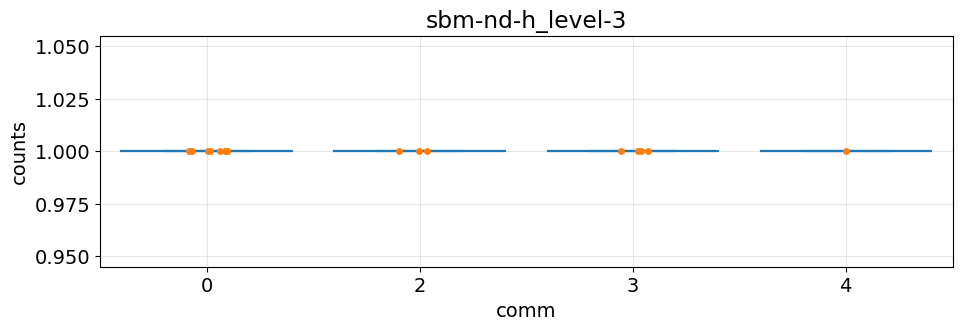

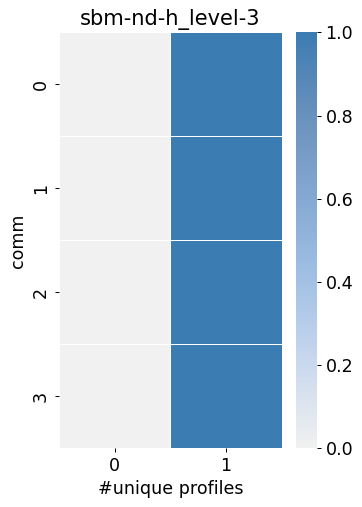

In [10]:
for sbm in sbms_list[:]:
    args.dc, args.sbm = sbm

    args.nested = args.sbm == 'h'

    args.force_niter = 40000
    args.num_draws = int((1/2) * args.force_niter)

    def sbm_name(args):
        dc = f'dc' if args.dc else f'nd'
        dc = f'' if args.sbm in ['a'] else dc
        file = f'sbm-{dc}-{args.sbm}'
        return file

    SBM = sbm_name(args)
    print(SBM)

    indiv_files = sorted(glob.glob(
        f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-marginals-df.pkl', 
        recursive=True
    ))
    display(indiv_files)

    args.eps = 0.3
    profiles_df = get_community_profiles(args, indiv_files)
    save_community_profiles(args, profiles_df)

    if args.sbm in ['a', 'd']:
        out_folder = f'{ESTIM_path}/group/community-profiles/{SBM}'
        os.system(f'mkdir -p {out_folder}')
        df = profiles_df

        fig = group_level_num_profiles(args, df)
        fig.savefig(f'{out_folder}/desc-num-profiles-barplot.pdf', bbox_inches='tight')

        # NUCPs: Number of Unique Community Profile s
        NUCPs, fig = get_group_level_num_unique_comm_profiles(args, profiles_df, level=-1)
        fig.savefig(f'{out_folder}/desc-num-profiles.pdf', bbox_inches='tight')
    if args.sbm in ['h']:
        for level in profiles_df['level'].unique():
            df = profiles_df[profiles_df['level'] == level].reset_index(drop=True)
            out_folder = f'{ESTIM_path}/group/community-profiles/{SBM}/level-{level}'
            os.system(f'mkdir -p {out_folder}')

            fig = group_level_num_profiles(args, df, level)
            fig.savefig(f'{out_folder}/desc-num-profiles-barplot.pdf', bbox_inches='tight')

            NUCPs, fig = get_group_level_num_unique_comm_profiles(args, df, level=level)
            fig.savefig(f'{out_folder}/desc-num-profiles.pdf', bbox_inches='tight')

In [11]:
profiles_df

,sub,level,comm,profile,strength
0,SLC01,0,0,"[0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0....",0.666
1,SLC01,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0...",0.333
2,SLC01,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.333
3,SLC01,0,2,"[0.0, 0.554, 0.879, 0.0, 0.0, 0.0, 0.782, 0.0,...",0.666
4,SLC01,0,2,"[0.0, 0.75, 0.711, 0.0, 0.0, 0.0, 0.053, 0.0, ...",0.190
...,...,...,...,...,...
962,SLC10,2,1,"[0.185, 0.078, 0.078, 0.184, 0.185, 0.178, 0.1...",0.940
963,SLC10,2,1,"[0.059, 0.063, 0.063, 0.065, 0.07, 0.061, 0.06...",0.061
964,SLC10,2,5,"[0.001, 0.041, 0.041, 0.003, 0.003, 0.017, 0.0...",0.273
965,SLC10,2,8,"[0.005, 0.021, 0.015, 0.005, 0.005, 0.005, 0.0...",0.133
